# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:


* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`. 

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

Number of faces detected: 1


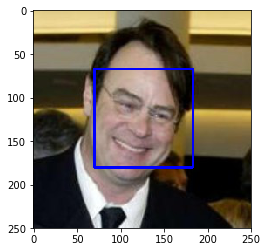

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector


In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

is_human = 0
is_dog = 0

for i in range(len(human_files_short)):
    human_output = face_detector(human_files_short[i])
    dog_output = face_detector(dog_files_short[i])
    
    if human_output:
        is_human += 1
    if dog_output:
        is_dog += 1
        
human_percentage = (is_human/len(human_files_short)) * 100
dog_percentage = (is_dog/len(dog_files_short)) * 100

print(human_percentage)
print(dog_percentage)


98.0
17.0


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, a function accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [7]:
from PIL import Image,ImageFile
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    
    img = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    
    model_input = transform(img).unsqueeze(0)
    
    if use_cuda:
        model_input = model_input.cuda()
        
    # Turn on evaluation mode
    VGG16.eval()
    
    # Get predicted category for image
    with torch.no_grad():
        output = VGG16(model_input)
        prediction = torch.argmax(output).item()
        
    # Turn off evaluation mode
    VGG16.train()
    
    return prediction # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

The `dog_detector` function below, returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction_key = VGG16_predict(img_path)
    
    if prediction_key >= 151 and prediction_key <= 268:
        return True
    else:
        return False

### Assess the Dog Detector

Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [9]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
is_human = 0
is_dog = 0

for i in range(len(human_files_short)):
    human_output = dog_detector(human_files_short[i])
    dog_output = dog_detector(dog_files_short[i])
    
    if human_output:
        is_human += 1
    if dog_output:
        is_dog += 1
        
human_percentage = (is_human/len(human_files_short)) * 100
dog_percentage = (is_dog/len(dog_files_short)) * 100

print(human_percentage)
print(dog_percentage)


0.0
100.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

### Specify Data Loaders for the Dog Dataset

In [11]:
import os
from torchvision import datasets

### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_valid_transforms = transforms.Compose([transforms.Resize(226),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder("/data/dog_images/train", transform = train_transforms)
valid_dataset = datasets.ImageFolder("/data/dog_images/valid", transform = test_valid_transforms)
test_dataset = datasets.ImageFolder("/data/dog_images/test", transform = test_valid_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

loaders_scratch = {'train':train_dataloader, 'valid':valid_dataloader, 'test':test_dataloader}


### Model Architecture

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(25088, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 133)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 25088)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        out = self.fc3(x)
        return out

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

5 different convolutional layers were used with kernel size of 3x3 and padding of 1. 

In between every convolutional layer, a max pool layer with kernel size and stride of 2 was used to half the feature maps. After the covolutional and max pooling layers, the feature maps were flattened to a 512 x 7 x 7 vector. 

Three fully connected layers were passed for classifcation taking the flattened vector as input and outputting 133 different classes of dog breeds. 

ReLU( ) was used as an activation function, followed by a Dropout( ) of 0.3. 

The last fully connected layer was not passed through an activation function since the CrossEntropyLoss( ) makes use of Softmax( ) on the model output and calculates the loss using NLLLoss( ). 

### Specify Loss Function and Optimizer

In [13]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### Train and Validate the Model

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in tqdm(range(1, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            
            output = model.forward(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))       
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model.forward(data)
            loss = criterion(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model at {}.'.format(
            valid_loss_min,
            valid_loss,
            save_path))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [15]:
# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 4.883405 	Validation Loss: 4.871981
Validation loss decreased (inf --> 4.872).  Saving model at model_scratch.pt.


  7%|▋         | 2/30 [03:31<50:31, 108.26s/it]

Epoch: 2 	Training Loss: 4.872663 	Validation Loss: 4.856431
Validation loss decreased (4.872 --> 4.856).  Saving model at model_scratch.pt.


 10%|█         | 3/30 [05:11<47:31, 105.60s/it]

Epoch: 3 	Training Loss: 4.868204 	Validation Loss: 4.841336
Validation loss decreased (4.856 --> 4.841).  Saving model at model_scratch.pt.


 13%|█▎        | 4/30 [06:50<44:55, 103.66s/it]

Epoch: 4 	Training Loss: 4.761992 	Validation Loss: 4.696176
Validation loss decreased (4.841 --> 4.696).  Saving model at model_scratch.pt.


 17%|█▋        | 5/30 [08:31<42:50, 102.81s/it]

Epoch: 5 	Training Loss: 4.703592 	Validation Loss: 4.648132
Validation loss decreased (4.696 --> 4.648).  Saving model at model_scratch.pt.


 20%|██        | 6/30 [10:12<40:58, 102.45s/it]

Epoch: 6 	Training Loss: 4.671071 	Validation Loss: 4.599093
Validation loss decreased (4.648 --> 4.599).  Saving model at model_scratch.pt.


 23%|██▎       | 7/30 [11:53<39:07, 102.05s/it]

Epoch: 7 	Training Loss: 4.636372 	Validation Loss: 4.537172
Validation loss decreased (4.599 --> 4.537).  Saving model at model_scratch.pt.


 27%|██▋       | 8/30 [13:35<37:20, 101.82s/it]

Epoch: 8 	Training Loss: 4.600105 	Validation Loss: 4.551941


 30%|███       | 9/30 [15:15<35:31, 101.49s/it]

Epoch: 9 	Training Loss: 4.580053 	Validation Loss: 4.463312
Validation loss decreased (4.537 --> 4.463).  Saving model at model_scratch.pt.


 33%|███▎      | 10/30 [16:57<33:47, 101.36s/it]

Epoch: 10 	Training Loss: 4.542867 	Validation Loss: 4.505432


 37%|███▋      | 11/30 [18:37<32:02, 101.21s/it]

Epoch: 11 	Training Loss: 4.521990 	Validation Loss: 4.392482
Validation loss decreased (4.463 --> 4.392).  Saving model at model_scratch.pt.


 40%|████      | 12/30 [20:18<30:20, 101.14s/it]

Epoch: 12 	Training Loss: 4.488296 	Validation Loss: 4.373781
Validation loss decreased (4.392 --> 4.374).  Saving model at model_scratch.pt.


 43%|████▎     | 13/30 [21:59<28:35, 100.90s/it]

Epoch: 13 	Training Loss: 4.459310 	Validation Loss: 4.512033


 47%|████▋     | 14/30 [23:37<26:42, 100.13s/it]

Epoch: 14 	Training Loss: 4.458792 	Validation Loss: 4.348351
Validation loss decreased (4.374 --> 4.348).  Saving model at model_scratch.pt.


 50%|█████     | 15/30 [25:17<25:02, 100.17s/it]

Epoch: 15 	Training Loss: 4.422493 	Validation Loss: 4.282481
Validation loss decreased (4.348 --> 4.282).  Saving model at model_scratch.pt.


 53%|█████▎    | 16/30 [26:57<23:20, 100.01s/it]

Epoch: 16 	Training Loss: 4.383218 	Validation Loss: 4.278745
Validation loss decreased (4.282 --> 4.279).  Saving model at model_scratch.pt.


 57%|█████▋    | 17/30 [28:36<21:37, 99.77s/it] 

Epoch: 17 	Training Loss: 4.377769 	Validation Loss: 4.199752
Validation loss decreased (4.279 --> 4.200).  Saving model at model_scratch.pt.


 60%|██████    | 18/30 [30:17<20:01, 100.14s/it]

Epoch: 18 	Training Loss: 4.338469 	Validation Loss: 4.179903
Validation loss decreased (4.200 --> 4.180).  Saving model at model_scratch.pt.


 63%|██████▎   | 19/30 [31:58<18:22, 100.23s/it]

Epoch: 19 	Training Loss: 4.318279 	Validation Loss: 4.186945


 67%|██████▋   | 20/30 [33:40<16:47, 100.79s/it]

Epoch: 20 	Training Loss: 4.271034 	Validation Loss: 4.183382


 70%|███████   | 21/30 [35:21<15:08, 100.96s/it]

Epoch: 21 	Training Loss: 4.239545 	Validation Loss: 4.122411
Validation loss decreased (4.180 --> 4.122).  Saving model at model_scratch.pt.


 73%|███████▎  | 22/30 [37:01<13:26, 100.77s/it]

Epoch: 22 	Training Loss: 4.208026 	Validation Loss: 4.171272


 77%|███████▋  | 23/30 [38:42<11:45, 100.82s/it]

Epoch: 23 	Training Loss: 4.195497 	Validation Loss: 4.004583
Validation loss decreased (4.122 --> 4.005).  Saving model at model_scratch.pt.


 80%|████████  | 24/30 [40:24<10:06, 101.12s/it]

Epoch: 24 	Training Loss: 4.156827 	Validation Loss: 4.030260


 83%|████████▎ | 25/30 [42:06<08:26, 101.22s/it]

Epoch: 25 	Training Loss: 4.123105 	Validation Loss: 4.029702


 87%|████████▋ | 26/30 [43:46<06:44, 101.09s/it]

Epoch: 26 	Training Loss: 4.103144 	Validation Loss: 3.912419
Validation loss decreased (4.005 --> 3.912).  Saving model at model_scratch.pt.


 90%|█████████ | 27/30 [45:28<05:03, 101.24s/it]

Epoch: 27 	Training Loss: 4.076410 	Validation Loss: 3.924994


 93%|█████████▎| 28/30 [47:08<03:21, 100.98s/it]

Epoch: 28 	Training Loss: 4.052781 	Validation Loss: 3.908263
Validation loss decreased (3.912 --> 3.908).  Saving model at model_scratch.pt.


 97%|█████████▋| 29/30 [48:49<01:40, 100.76s/it]

Epoch: 29 	Training Loss: 4.054587 	Validation Loss: 3.859529
Validation loss decreased (3.908 --> 3.860).  Saving model at model_scratch.pt.


100%|██████████| 30/30 [50:27<00:00, 100.18s/it]

Epoch: 30 	Training Loss: 4.009593 	Validation Loss: 3.856633
Validation loss decreased (3.860 --> 3.857).  Saving model at model_scratch.pt.


### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.843379


Test Accuracy: 10% (86/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

In [17]:
## TODO: Specify data loaders
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_valid_transforms = transforms.Compose([transforms.Resize(226),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder("/data/dog_images/train", transform = train_transforms)
valid_dataset = datasets.ImageFolder("/data/dog_images/valid", transform = test_valid_transforms)
test_dataset = datasets.ImageFolder("/data/dog_images/test", transform = test_valid_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

data_transfer = {'train':train_dataset, 'valid':valid_dataset, 'test':test_dataset}
loaders_transfer = {'train':train_dataloader, 'valid':valid_dataloader, 'test':test_dataloader}

### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [18]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(nn.Dropout(0.3),
                           nn.Linear(25088, 1024),
                           nn.ReLU(),
                           nn.Dropout(0.3),
                           nn.Linear(1024, 256),
                           nn.ReLU(),
                           nn.Dropout(0.3),
                           nn.Linear(256, 133))

model_transfer.classifier = classifier
                           
if use_cuda:
    model_transfer = model_transfer.cuda()

The VGG16 model was chosen as it was allready trained to classify various different images, including dogs. The convolutional and max pooling parameters were frozen and replaced the model's clasifier with my own. 

I made use of 3 different fully conencted layers with an input of 25088 and output of 133 (number of dog breed classes). 

ReLU( ) was used as an activation layer, followed by a Dropout( ) of 0.3. Since CrossEntropyLoss( ) is later used to calculate the loss, the last FC layer was not passed through an activation layer.

### Specify Loss Function and Optimizer

In [19]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

### Train and Validate the Model

In [20]:
# train the model
model_transfer = train(5, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 4.016248 	Validation Loss: 1.866798
Validation loss decreased (inf --> 1.867).  Saving model at model_transfer.pt.


 20%|██        | 1/5 [01:52<07:30, 112.68s/it]

Epoch: 2 	Training Loss: 2.641885 	Validation Loss: 1.250562
Validation loss decreased (1.867 --> 1.251).  Saving model at model_transfer.pt.


 40%|████      | 2/5 [03:46<05:38, 112.95s/it]

Epoch: 3 	Training Loss: 2.282442 	Validation Loss: 1.056196
Validation loss decreased (1.251 --> 1.056).  Saving model at model_transfer.pt.


 60%|██████    | 3/5 [05:40<03:46, 113.27s/it]

Epoch: 4 	Training Loss: 2.137404 	Validation Loss: 0.977858
Validation loss decreased (1.056 --> 0.978).  Saving model at model_transfer.pt.


 80%|████████  | 4/5 [07:34<01:53, 113.43s/it]

Epoch: 5 	Training Loss: 2.054341 	Validation Loss: 0.932945
Validation loss decreased (0.978 --> 0.933).  Saving model at model_transfer.pt.


100%|██████████| 5/5 [09:28<00:00, 113.69s/it]


### Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [21]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.022868


Test Accuracy: 70% (587/836)


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [22]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    
    model_input = transform(img).unsqueeze(0)
    
    if use_cuda:
        model_input = model_input.cuda()
        
    # Turn on evaluation mode
    model_transfer.eval()
    
    # Get predicted category for image
    with torch.no_grad():
        output = model_transfer(model_input)
        prediction = torch.argmax(output).item()
        
    # Turn off evaluation mode
    model_transfer.train()
    
    return class_names[prediction]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


### Write your Algorithm

In [29]:
### Write your algorithm.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    #Check for human face:
    is_human = face_detector(img_path)
    
    #Check if dog:
    is_dog = dog_detector(img_path)
    
    if is_human == True and is_dog == False or is_human == True and is_dog == True:
        plt.imshow(Image.open(img_path))
        plt.show()
        print("You look like a: {}.".format(predict_breed_transfer(img_path)))
        
    elif is_human == False and is_dog == True:
        plt.imshow(Image.open(img_path))
        plt.show()
        print("This dog is a: {}.".format(predict_breed_transfer(img_path)))
              
    else:
        plt.imshow(Image.open(img_path))
        plt.show()
        print("No Dog/Human were detected.")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

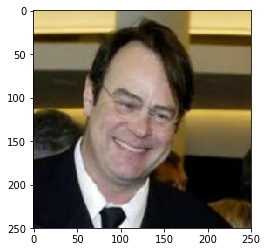

You look like a: Australian cattle dog.


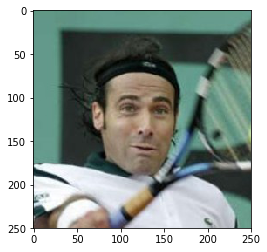

You look like a: Silky terrier.


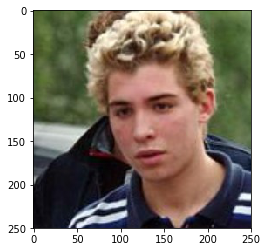

You look like a: Chesapeake bay retriever.


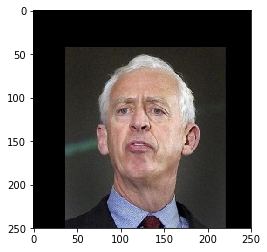

You look like a: Nova scotia duck tolling retriever.


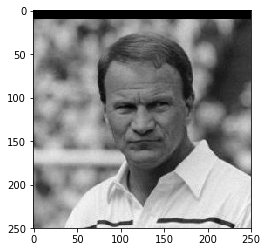

You look like a: American staffordshire terrier.


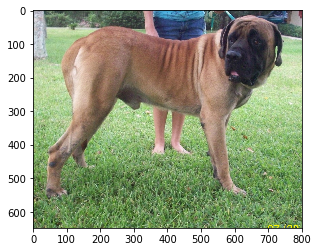

This dog is a: Bullmastiff.


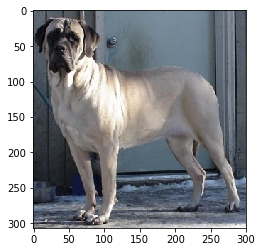

This dog is a: Bullmastiff.


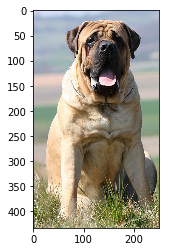

This dog is a: Bullmastiff.


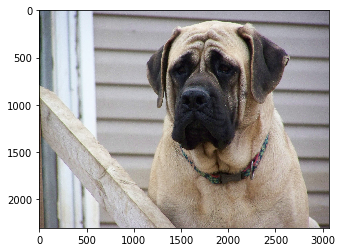

This dog is a: Bullmastiff.


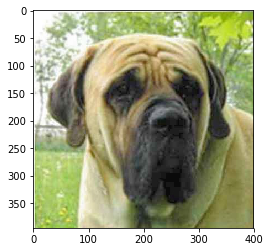

This dog is a: Mastiff.


In [30]:
## Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:5], dog_files[:5])):
    run_app(file)

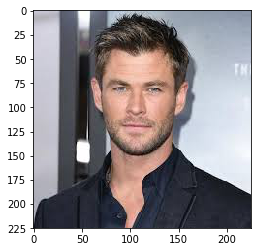

You look like a: Belgian malinois.


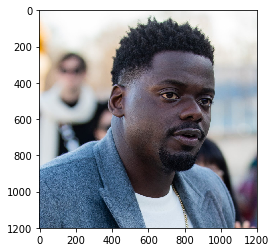

You look like a: Chesapeake bay retriever.


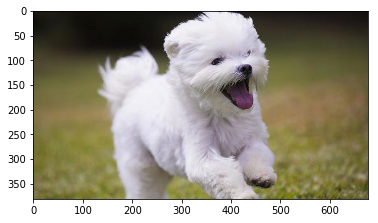

This dog is a: Maltese.


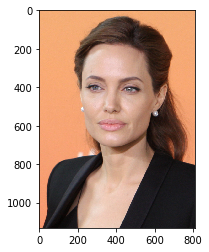

You look like a: Italian greyhound.


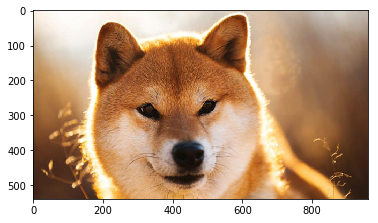

No Dog/Human were detected.


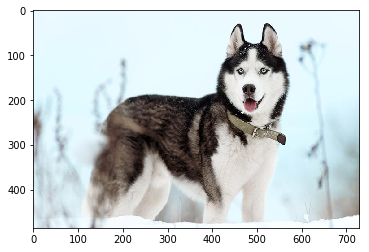

You look like a: Alaskan malamute.


In [31]:
from glob import glob

# load images from folder step6_images
files = np.array(glob("step6_images/*"))
for file_path in files:
    run_app(file_path)